# Magic The Gathering: Arena and Card Shuffling

## Premise

My friend and I have been playing [Magic The Gathering: Arena](https://magic.wizards.com/en/mtgarena) which has been super great to have [someone else figure out the rules](https://xkcd.com/1566/), but i've been upset with a couple of the hands i'm drawing. In MTG, "mana" serves as the basic building block for the game and without it you can't do much, so it's important to be able to setup a foundation to work on top of. This is primarily done by playing "lands" that look like the following:

<img src="https://img.scryfall.com/cards/large/en/rix/195.jpg?1524752819" width=250>

So you're always looking for a good balance between a strong foundation and the "spells" or actions to actually use the building blocks.

The numbers vary but typically it's recommended to have anywhere between 18-24 land cards in your deck out of a total of 60 cards. 

In [1]:
totalCards = 60
landCards = 20

The issue that I ran into and would like to explore is how the cards are distributed. Let's do some math and find out some theoretical and empirical results.

Let's look into the probabilities of drawing cards.

If we draw a single card, the probabiltiy of getting a specific card would be $p(a) = \frac{\text{favorable possibility}}{\text{all possible}}$

In our case, drawing a land would be $\frac{20}{60} = \frac{1}{3} = 33\%$. That's a pretty high likelihood. Let's keep moving forward. Assuming that we did in fact draw a land, the probability of the next card being a land would be $\frac{19}{59} = 32.3\%$. Still pretty high! This will get pretty nausiating to write out by hand, let's define a function which can give us these probabilities.

In [2]:
def singleCardDrawProbability(favorable, allPossible, cardsToDraw):
    cardLikelihoods = []
    for i in range(cardsToDraw):
        cardLikelihoods.append((favorable-i)/(allPossible-i))
    return cardLikelihoods

In [3]:
print(singleCardDrawProbability(20,60,7))

[0.3333333333333333, 0.3220338983050847, 0.3103448275862069, 0.2982456140350877, 0.2857142857142857, 0.2727272727272727, 0.25925925925925924]


Let's make this look a bit nicer.

In [4]:
tempVariable = singleCardDrawProbability(20,60,7)
for index,percentage in enumerate(tempVariable):
    print(str(index+1)+" draw: {:.2%}".format(percentage))

1 draw: 33.33%
2 draw: 32.20%
3 draw: 31.03%
4 draw: 29.82%
5 draw: 28.57%
6 draw: 27.27%
7 draw: 25.93%


Numbers are hard to understand, and since we have a nice time-based data-series, let's get some graphs in here.

In [5]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import math
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline

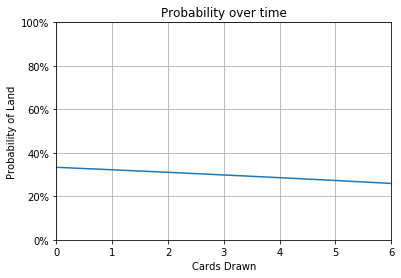

In [6]:
seriesRange = np.arange(len(tempVariable))
plt.plot(seriesRange, tempVariable)

# Plot labels and formatting
plt.title("Probability over time")
plt.xlabel('Cards Drawn')
plt.ylabel('Probability of Land')
plt.xlim([0,len(seriesRange)-1])
plt.ylim([0,1])
plt.grid(True)

ax1 = plt.gca()
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

But this is the probability of drawing a single card out of the deck. What we need to do is look at the chances of specifically drawing the specific combination. This will paint a drastically different picture.

To do this we need to look at the probability of a single event, multiplied by the following event. So we will multiple all of our probabilities together over time.

In [7]:
def singleCardDrawMultiplicativeProbability(favorable, allPossible, cardsToDraw):
    cardLikelihoods = []
    for i in range(cardsToDraw):
        cardLikelihoods.append((favorable-i)/(allPossible-i))
    return np.prod(cardLikelihoods)

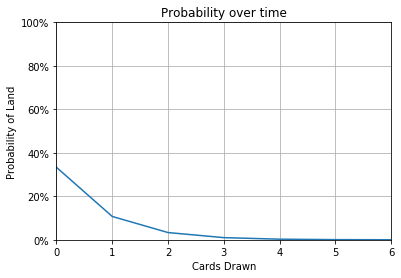

In [8]:
drawsOverTime = [singleCardDrawMultiplicativeProbability(20,60,i+1) for i in range(7)]
seriesRange = np.arange(len(drawsOverTime))
plt.plot(seriesRange, drawsOverTime)

# Plot labels and formatting
plt.title("Probability over time")
plt.xlabel('Cards Drawn')
plt.ylabel('Probability of Land')
plt.xlim([0,len(seriesRange)-1])
plt.ylim([0,1])
plt.grid(True)

ax1 = plt.gca()
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

So a fairly probable amount but something that definitely decreases overtime. But this is theoretical data, which gives us a sense of what *could* happen. Let's use empirical data to validate our results.

To do this we're going to use a random variable, and "mill" (term for drawing all possible cards) ourselves and see what sort of data we get over time.

To define this programatically, let's use `True` to define a land card, and `False` to define anything else.

In [9]:
boolean_deck = np.arange(totalCards) < 20

This is a cool way of generating our "deck". Here we generate an array from 0 -> 60 (i.e. 0,1,2,3,...,59) then we evaluate each value if it is `< 20`. This gives us a list where 20 items are `True` and the rest are `False`. Here's a validation of that:

In [10]:
print(boolean_deck)
unique, counts = np.unique(boolean_deck, return_counts=True)
print(dict(zip(unique, counts)))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
{False: 40, True: 20}


There are a couple ways that we can go about "drawing" cards, and for the sake of this next part, we're going to shuffle the array and look at the stack of cards.

In [11]:
# Note: We want to abstract the function of shuffling so that we can change it in the future
#       In this case, np.random.shuffle shuffles the array in place, so we don't need to return anything 
def shuffleDeck(given_deck):
    np.random.shuffle(given_deck)

In [12]:
shuffleDeck(boolean_deck)
print(boolean_deck)

[False False False False  True False False  True False  True  True False
  True  True False False False False False False  True False False False
 False False False False False False  True False False False False  True
  True False False  True  True False  True  True False False False  True
 False False False  True  True  True False False  True False  True False]


That's hard to read, let's visualize it as if we were drawing cards over time.

In [13]:
def generateGraph(givenDeck):
    rollingCount = [1 if x==True else -1 for x in givenDeck]
    seriesRange = np.arange(len(rollingCount))
    fig, ax = plt.subplots()
    ax.set_yticklabels(["","","spell","","","", "land"], minor=False)
    
    
    plt.plot(seriesRange, rollingCount, linewidth=3.0)

    # Plot labels and formatting
    plt.title("Land Drawn over time")
    plt.xlabel('Cards Drawn')
    plt.ylabel('Card Type')
    plt.xlim([0,len(seriesRange)-1])
    plt.ylim([-2,2])
              
    plt.grid(True,alpha=0.5, linestyle='--')

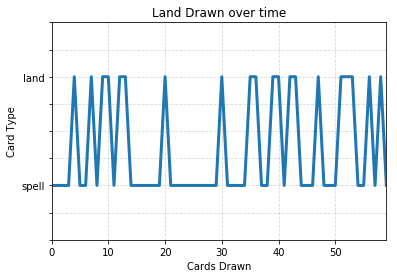

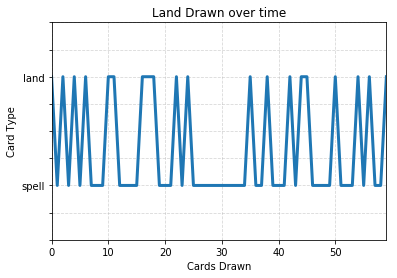

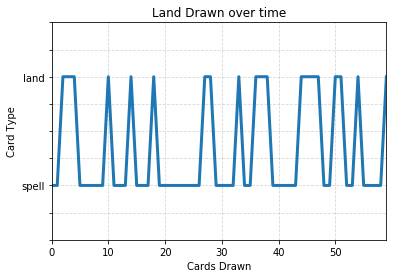

In [14]:
generateGraph(boolean_deck)
shuffleDeck(boolean_deck)
generateGraph(boolean_deck)
shuffleDeck(boolean_deck)
generateGraph(boolean_deck)

So looking at these graph, it's totally possible to grab several cards in a row. Let's define some more functions to help visualize *consecutive* land draws. We're interested in seeing how often a land, or `True`, value repeats to the next index. We'll also generalize this through the use of `consecutiveLimit` so that later on we can see other groupings of values (ex. only show 3 in a row)

In [15]:
def count_consecutive(given_deck, consecutiveLimit=1):
    runningCount = 0
    consecutiveAmounts = []
    for card_index in range(len(given_deck)):
        if given_deck[card_index] == True:
            runningCount += 1
        else:
            if runningCount > consecutiveLimit:
                consecutiveAmounts.append(runningCount)
            runningCount = 0
    return consecutiveAmounts

In [16]:
count_consecutive(boolean_deck)

[3, 2, 3, 4, 2]

Let's generalize some more functions. 

To generate a deck (a list of true or false values) we'll abstract it behind a function.

Since we're interested in simulating this a lot of times, let's create a function that will take a deck, shuffle it, and append the results to a larger list. 

Finally let's have a function take that larger list and create a histogram visualization 

In [17]:
def generateSingleDeck(deckSize, landCount):
    return np.arange(deckSize) < landCount

In [18]:
def multipleDeckCounts(deckToShuffle, timesToShuffle, consecutiveLimit=1, verbose=False):
    countList = []
    for i in range(timesToShuffle):
        shuffleDeck(deckToShuffle)
        countList.append(count_consecutive(deckToShuffle, consecutiveLimit))
    flattened_list  = list(itertools.chain(*countList))
    
    if verbose:
        unique, counts = np.unique(flattened_list, return_counts=True)
        print(dict(zip(unique, counts)))
    
    return flattened_list

In [19]:
def histograms(given_list, amountAttempted):
    plt.grid(True,alpha=0.5, linestyle='--', zorder=0, axis='y')
    
    data = np.array(given_list)
    d = np.diff(np.unique(given_list)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), edgecolor='black', linewidth=1.2, zorder=3)

    plt.title('Simulating '+ str(amountAttempted) + ' decks')
    plt.xlabel('Consecutive Land Quantity')
    plt.ylabel('Occurances')
    plt.xticks(range(int(left_of_first_bin),int(right_of_last_bin)+1))
    
    plt.show()

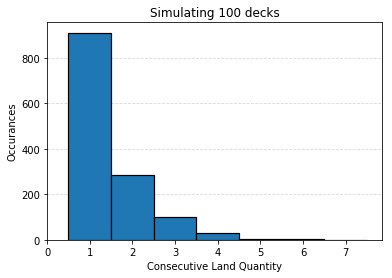

In [20]:
sample_deck = generateSingleDeck(60,20)

timesToTry = 100
generatedCounts = multipleDeckCounts(sample_deck, timesToTry, 0)
histograms(generatedCounts, timesToTry)

Looks pretty interesting. Let's look at our function from earlier and see how the two graphs overlay.

In [60]:
def overlayedGraphs(given_deck,timesToTry=100,maxRange=7):
    
    # Histogram Data
    given_list = multipleDeckCounts(given_deck, timesToTry, -1)
    deckData = np.array(given_list)
    
    d = np.diff(np.unique(deckData)).min()
    left_of_first_bin = deckData.min() - float(d)/2
    right_of_last_bin = deckData.max() + float(d)/2
       
    # Probability Data
    probOverTime = [singleCardDrawMultiplicativeProbability(20,60,i+1) for i in range(deckData.max()+1)]
    
    # Set up plots
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # Plot Histogram
    blueColor = 'tab:blue'
    ax1.set_ylabel('Card n-tuple\'s drawn',color=blueColor)
    
    ax1.tick_params(axis='y', labelcolor=blueColor)
    ax1.grid(which='major',axis='y',linestyle='--')
    ax1.hist(deckData, 
             np.arange(left_of_first_bin, right_of_last_bin + d, d), 
             edgecolor='black', 
             linewidth=1.2, 
             zorder=2,
             weights=np.full_like(deckData,timesToTry),
             label='Consecutive Land Draws')
    ax1.set_xlabel('Consecutive Land Draws')
    
    # Plot Probability 
    redColor = 'tab:red'
    
    ax2.set_ylabel('% Chance',color=redColor)
    ax2.tick_params(axis='y', labelcolor=redColor)
    
    ax2.plot(np.arange(deckData.max()+1), 
             probOverTime, 
             label="Consecutive Draw Chance", 
             color=redColor, 
             linewidth=3, 
             zorder=3)
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    
    #ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
    
    #Setup nice things            
    plt.title('Simulating '+ str(timesToTry) + ' decks')
    plt.xlabel('Consecutive Land Quantity')
    plt.ylabel('Probability of Land')
    plt.xticks(range(int(left_of_first_bin),int(right_of_last_bin)+1))
    
    
    fig.tight_layout()    
    fig.legend(loc="upper right", bbox_to_anchor=(0.85,0.9))

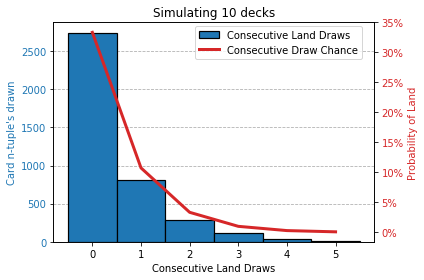

In [61]:
sample_deck = generateSingleDeck(60,20)
overlayedGraphs(sample_deck,10,maxRange=7)

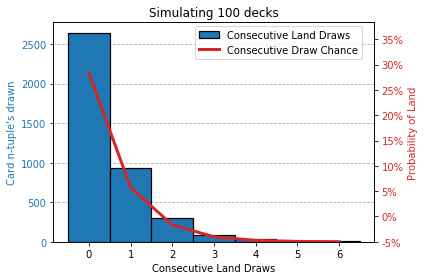

In [41]:
sample_deck = generateSingleDeck(60,20)
overlayedGraphs(sample_deck,100,maxRange=7)

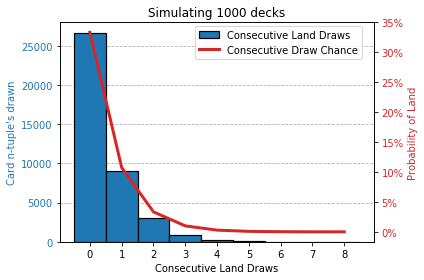

In [24]:
sample_deck = generateSingleDeck(60,20)
overlayedGraphs(sample_deck,1000,maxRange=7)

That's pretty neat, our empirical data matches with the theoretical numbers. What we can see is that it's fairly unlikely to draw multiple lands consecutively.

## Bad Decks